# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'gsk3_jnk3_qed_sa')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'gsk3_jnk3')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 781797
Number of vocabulary: 53687
Maximum of seqlen: 40


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 40,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'gsk3_jnk3_qed_sa', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_gsk3_jnk3 as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward()

In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft, zeta=0.9999)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                  gsk_list, jnk_list,
                  execution_times, filepath):
    
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "GSK3":gsk_list,
                               "JNK3":jnk_list,
                               "EXEC_TIME":execution_times})
    
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 50
behavior_stepsize = 20

[0001] rl_loss: 2.182	reconst_loss: 2.098	entropy_loss: 0.085	reward: 0.867	tau: 0.306	(31.084 sec)
[0002] rl_loss: 1.748	reconst_loss: 1.661	entropy_loss: 0.087	reward: 0.695	tau: 0.310	(65.692 sec)
[0003] rl_loss: 1.617	reconst_loss: 1.527	entropy_loss: 0.089	reward: 0.621	tau: 0.313	(108.578 sec)
[0004] rl_loss: 2.413	reconst_loss: 2.327	entropy_loss: 0.086	reward: 0.955	tau: 0.319	(168.559 sec)
[0005] rl_loss: 2.125	reconst_loss: 2.039	entropy_loss: 0.086	reward: 0.782	tau: 0.324	(288.360 sec)
[0006] rl_loss: 2.652	reconst_loss: 2.553	entropy_loss: 0.099	reward: 0.988	tau: 0.330	(350.146 sec)
[0007] rl_loss: 1.817	reconst_loss: 1.708	entropy_loss: 0.109	reward: 0.794	tau: 0.335	(411.485 sec)
[0008] rl_loss: 3.759	reconst_loss: 3.658	entropy_loss: 0.101	reward: 1.350	tau: 0.345	(472.262 sec)
[0009] rl_loss: 1.412	reconst_loss: 1.309	entropy_loss: 0.103	reward: 0.436	tau: 0.346	(533.084 sec)
[0010] rl_loss: 1.079	reconst_loss: 0.964	entropy_loss: 0.115	reward: 0.625	tau: 0.349	(595.0

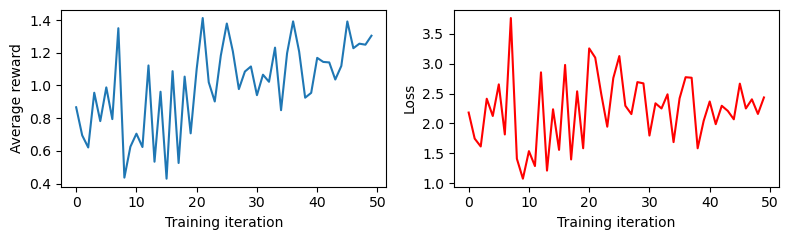

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.36it/s]


Sample trajectories: 100
[0.020, 0.000]    CC(C)(C1)CC(=O)CC(C1)C(=O)C=CCOC2=CC=CC=C2
[0.010, 0.000]    O=CC1=NC=C2S1C=CC(Br)=CC2Cl
[0.060, 0.010]    O=C1C=C(C2=CC=CC=C2)OC3=CC(=CC=C13)OCC4=CC=C(F)C=C4
[0.040, 0.040]    CCCCCN(C)S(=O)(=O)C1=CC=C2N=C(C=CC2=C1)C3=CC=C(C=C3)C4=CC=CC=C4
[0.170, 0.020]    CC(C)C1=CC=C(C=C1)CC=C(C2=CC=C(Cl)C=C2)NCC3CCCN3C=NC(C)CCCCCC45NC=CNC=C4OC6C5CCCC6
[0.060, 0.080]    CC(C)C1=CC=C(C=C1)C=NNC(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)C4=CC=C(C(O)=O)C=C4NC(=O)C5CC6=CC(Cl)=CC(Cl)=C6S5
[0.450, 0.200]    O=C(C1=CC=C(F)C=C1)NC2=CC=C3NN=C(C3=C2)C4=CC=C(F)C=C4
[0.020, 0.010]    C=C(NS(C)(=O)=O)C(=O)CCOC(=O)C1=CC=C2C=CC=CC2=C1
[0.090, 0.100]    N#CC=C(N)CN=C(C1=CC=CC2=C1Cl)C=C(O)C=C=CC3=CC=CN=C3C=C2C4=C(O)C=CC=C4[N+1](=O)[O-1]
[0.230, 0.020]    N1=C2C=C3NCC=NC4=C1C=NC(C4=O)=CC=C32
[0.000, 0.000]    CC(C)CC(=O)N1CCN(CC1)OC2C=NN(N=C2)C3=CC=CC(F)=C3
[0.100, 0.100]    C=CC=CC=CSCCCCCCNC1=CC=NC2=CC(Cl)=CC=C12
[0.900, 0.540]    CC(C)C1=NC(C)=C(S1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCNCC4

[0064] rl_loss: 2.245	reconst_loss: 1.949	entropy_loss: 0.296	reward: 1.451	tau: 0.698	(4180.988 sec)
[0065] rl_loss: 2.460	reconst_loss: 2.162	entropy_loss: 0.298	reward: 1.588	tau: 0.707	(4221.964 sec)
[0066] rl_loss: 2.714	reconst_loss: 2.415	entropy_loss: 0.299	reward: 1.645	tau: 0.716	(4261.084 sec)
[0067] rl_loss: 2.302	reconst_loss: 1.993	entropy_loss: 0.309	reward: 1.599	tau: 0.725	(4300.803 sec)
[0068] rl_loss: 2.154	reconst_loss: 1.844	entropy_loss: 0.309	reward: 1.448	tau: 0.732	(4340.247 sec)
[0069] rl_loss: 2.460	reconst_loss: 2.145	entropy_loss: 0.315	reward: 1.676	tau: 0.742	(4380.729 sec)
[0070] rl_loss: 2.491	reconst_loss: 2.172	entropy_loss: 0.319	reward: 1.720	tau: 0.751	(4420.793 sec)
[0071] rl_loss: 2.331	reconst_loss: 2.009	entropy_loss: 0.322	reward: 1.676	tau: 0.761	(4460.868 sec)
[0072] rl_loss: 2.024	reconst_loss: 1.698	entropy_loss: 0.326	reward: 1.565	tau: 0.769	(4500.653 sec)
[0073] rl_loss: 2.283	reconst_loss: 1.953	entropy_loss: 0.330	reward: 1.698	tau: 0

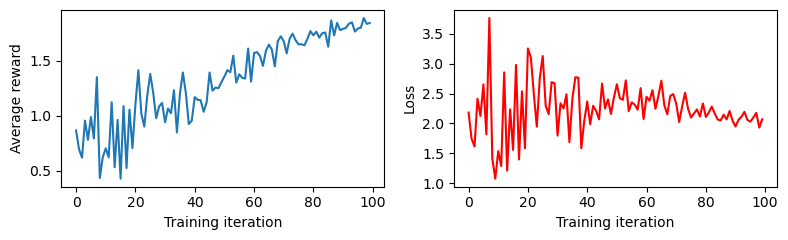

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.46it/s]


Sample trajectories: 100
[0.080, 0.030]    CCC(C(O)=O)OC1=CC=CC=C1C2=CC(=NC(N)=N2)C=CC3=CC=C(O)C=C3
[0.780, 0.670]    N1C(=C1F)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CN=C4
[0.020, 0.000]    O=C(C1=CC=CN=C1)NC2=CC=C(C=C2)NC=O
[0.740, 0.710]    O=C(NO)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.070, 0.000]    C=NC=CC=CNC=NC1=CC=C(C=C1)N2C=NC3=CC=CC=C32
[0.030, 0.000]    NC1=CC(=O)N(C=C1F)C2=CC=CC=C2
[0.260, 0.180]    CC1=CC(F)=CC=C1C2=NC(=CC=C2OC)C3=CC=C(C=C3)NC(=O)C4=CC=C(C=C4)S(=O)(=O)NC5=CC=C(C=C5)CCNCC(O)C6=CC=CN=C6
[0.740, 0.660]    CC(C)NCC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.070, 0.000]    N1C2(C1O)C3C=CC=CC3=N2
[0.010, 0.020]    COC1=CC=C(C=C1)NC(=O)N2CCCC2(C)NC(=O)C3=CC=C(C=C3)N(C4=CC=CC=C4)C5=NN(N=N5)C6=CC=CC=C6
[0.020, 0.000]    OC1=CC=C(Cl)S1NCCOCCCCCCCCCCCCCCCC2CCN(CC2)C(=O)OC(C)(C)C
[0.060, 0.060]    CNCCCCC1=C2NC=CC=CC=C1C(=O)O2
[0.200, 0.300]    CNC1=CC(=NC=N1)NC2=CC=C(C(OC)=C2)CN3CCOCC3
[0.000, 0.000]    C123C=CC(C1=C2)=C(C)N3C4=CC=C(F)C=C4
[0.000, 0.000]    S(=O)=O
[0.740, 

[0116] rl_loss: 1.737	reconst_loss: 1.248	entropy_loss: 0.489	reward: 1.898	tau: 1.140	(6383.370 sec)
[0117] rl_loss: 1.949	reconst_loss: 1.456	entropy_loss: 0.493	reward: 1.913	tau: 1.148	(6427.700 sec)
[0118] rl_loss: 1.817	reconst_loss: 1.320	entropy_loss: 0.497	reward: 1.934	tau: 1.156	(6472.595 sec)
[0119] rl_loss: 2.170	reconst_loss: 1.672	entropy_loss: 0.499	reward: 1.942	tau: 1.164	(6518.636 sec)
[0120] rl_loss: 1.937	reconst_loss: 1.434	entropy_loss: 0.503	reward: 1.921	tau: 1.171	(6563.046 sec)
[0121] rl_loss: 1.938	reconst_loss: 1.431	entropy_loss: 0.506	reward: 1.903	tau: 1.179	(6606.493 sec)
[0122] rl_loss: 1.875	reconst_loss: 1.366	entropy_loss: 0.509	reward: 1.963	tau: 1.187	(6651.796 sec)
[0123] rl_loss: 1.730	reconst_loss: 1.214	entropy_loss: 0.516	reward: 1.934	tau: 1.194	(6696.544 sec)
[0124] rl_loss: 1.756	reconst_loss: 1.236	entropy_loss: 0.520	reward: 1.943	tau: 1.201	(6743.678 sec)
[0125] rl_loss: 1.863	reconst_loss: 1.342	entropy_loss: 0.521	reward: 1.962	tau: 1

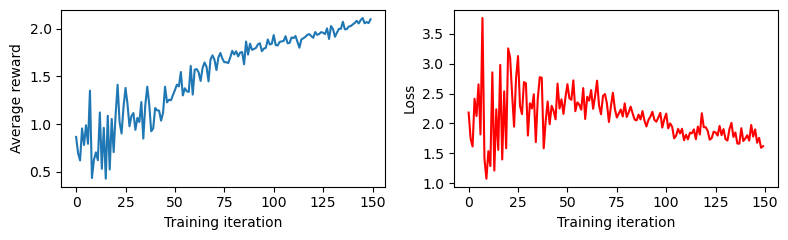

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.51it/s]


Sample trajectories: 100
[0.010, 0.010]    O=C(NO)C=C(C1=CC=CC=C1)C(=O)N2CCOCC2
[0.720, 0.650]    O=C(C(F)(F)F)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.730, 0.430]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3C(SC)=NC4=CC=C(OC)C=C4
[0.700, 0.680]    O=C(C(F)(F)F)NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.840, 0.560]    O=C(O)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC(=C3)CC
[0.010, 0.000]    CC(C)(C(O)=O)C1=CC=CC=C1Cl
[0.720, 0.590]    CC1=CC(=CC(C)=C1Cl)OC2=CC=C(C=N2)NC3=NC=CC(=N3)C4=CC=CN=C4
[0.000, 0.000]    CN1CCC=C(C1)C2=CC=CC=C2
[0.730, 0.640]    O=C(NCC1=CC=C(F)C=C1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CN=C4
[0.730, 0.690]    O=CC1CCCCN1C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CN=C4
[0.750, 0.590]    COC1=CC(=CC(OC)=C1OC)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.740, 0.590]    CC(=O)NC1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.300, 0.050]    NC=NN=C1NC=CN=C2C=CC=CC2N=CN=C1C3=CC=NC=C3
[0.750, 0.590]    COC1=CC(=CC(OC)=C1OC)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.780, 0.560]    NC(=O)C1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=CC(F)=C3


[0166] rl_loss: 1.815	reconst_loss: 1.140	entropy_loss: 0.675	reward: 2.211	tau: 1.503	(8680.238 sec)
[0167] rl_loss: 1.579	reconst_loss: 0.900	entropy_loss: 0.679	reward: 2.209	tau: 1.510	(8726.271 sec)
[0168] rl_loss: 1.791	reconst_loss: 1.111	entropy_loss: 0.679	reward: 2.261	tau: 1.518	(8772.075 sec)
[0169] rl_loss: 1.672	reconst_loss: 0.988	entropy_loss: 0.684	reward: 2.251	tau: 1.525	(8819.240 sec)
[0170] rl_loss: 1.641	reconst_loss: 0.953	entropy_loss: 0.688	reward: 2.249	tau: 1.532	(8865.552 sec)
[0171] rl_loss: 1.851	reconst_loss: 1.160	entropy_loss: 0.691	reward: 2.276	tau: 1.540	(8913.557 sec)
[0172] rl_loss: 1.880	reconst_loss: 1.184	entropy_loss: 0.697	reward: 2.235	tau: 1.547	(8958.431 sec)
[0173] rl_loss: 1.715	reconst_loss: 1.014	entropy_loss: 0.701	reward: 2.281	tau: 1.554	(9003.906 sec)
[0174] rl_loss: 1.705	reconst_loss: 1.003	entropy_loss: 0.703	reward: 2.267	tau: 1.561	(9050.732 sec)
[0175] rl_loss: 1.725	reconst_loss: 1.020	entropy_loss: 0.706	reward: 2.248	tau: 1

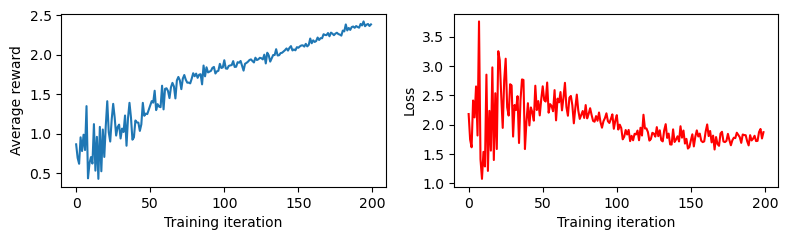

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.63it/s]


Sample trajectories: 100
[0.790, 0.650]    CC1=CC=CC(=N1)NC(=O)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.810, 0.700]    CC1=CC=CC=C1C(=O)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.780, 0.720]    O=C(C1=CC=CS1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=C(F)C=C4
[0.740, 0.660]    CC(C1=CC=CC=C1)N2C(=O)N(CC(C)(C)N2)C3=CC=C(C=C3)NC4=NC=CC(=N4)C5=CC=CC=C5
[0.860, 0.520]    O=C(N1CCOCC1)C2=CC=CC(=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.050, 0.010]    O=C(O)C1=NC2=NC(Cl)=CC=C2N=C1C3=CC=CC(Cl)=C3
[0.740, 0.500]    COC1=CC=C2NC=C(C2=C1)CN(C)CC=C3N(C(C)(C)C)C(=O)C=C3C4=CC(=CC=C4)C5=CC=NC(=N5)NC6=CC=C(C=C6)OC7CCCC7
[0.690, 0.550]    N#CC1=CC=C(C(F)=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.270, 0.110]    NC(=O)C1=CC=C(S1)NC2=NC3=C(C=NN3C=C2)C4=CC=C(F)C=C4
[0.730, 0.640]    O=C(NCC1=CC=C(F)C=C1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CN=C4
[0.770, 0.690]    C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.770, 0.750]    NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.740, 0.660]    O=C(O)CCCCCC1CC(=NO1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.

[0212] rl_loss: 1.946	reconst_loss: 1.100	entropy_loss: 0.845	reward: 2.440	tau: 1.818	(10819.803 sec)
[0213] rl_loss: 1.746	reconst_loss: 0.903	entropy_loss: 0.844	reward: 2.412	tau: 1.824	(10866.244 sec)
[0214] rl_loss: 1.823	reconst_loss: 0.972	entropy_loss: 0.850	reward: 2.460	tau: 1.831	(10912.261 sec)
[0215] rl_loss: 1.985	reconst_loss: 1.130	entropy_loss: 0.855	reward: 2.451	tau: 1.837	(10958.603 sec)
[0216] rl_loss: 1.806	reconst_loss: 0.951	entropy_loss: 0.855	reward: 2.460	tau: 1.843	(11003.929 sec)
[0217] rl_loss: 1.839	reconst_loss: 0.975	entropy_loss: 0.863	reward: 2.467	tau: 1.849	(11049.871 sec)
[0218] rl_loss: 1.779	reconst_loss: 0.913	entropy_loss: 0.866	reward: 2.479	tau: 1.856	(11095.406 sec)
[0219] rl_loss: 1.928	reconst_loss: 1.059	entropy_loss: 0.868	reward: 2.454	tau: 1.862	(11143.449 sec)
[0220] rl_loss: 1.806	reconst_loss: 0.936	entropy_loss: 0.870	reward: 2.472	tau: 1.868	(11189.452 sec)
[0221] rl_loss: 1.933	reconst_loss: 1.055	entropy_loss: 0.878	reward: 2.4

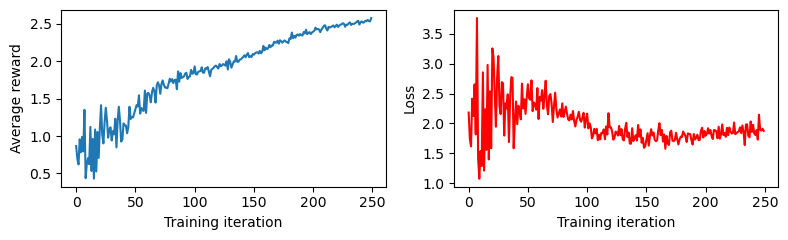

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.26it/s]


Sample trajectories: 100
[0.850, 0.720]    CNC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.780, 0.670]    NC1=CC=C(C=N1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.530, 0.320]    N#CC1=CC=C(C=C1)NC2=NC=C3C(=N2)C4=CC=CC=C4C3
[0.110, 0.010]    N=C(N)C1=CC=C2OC(=CC2=C1)C3=CC(=C4C=N3)N5CCCC(C5)O4
[0.760, 0.680]    O=COC1=CC=CC=CC=CC=C1C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.360, 0.080]    C=C1C(C(N)=NN1)C2CCN(CC2)C3=NC=NC4=C3C=NN4
[0.870, 0.570]    O=C(C=C)C1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.760, 0.730]    CC(=O)NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.760, 0.790]    O=C(NN=CC1=CC=CC=C1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.070, 0.030]    CNC(=O)CSCC=CC=CC(C1=CC=CC=C1)C2=CC=C(O)C(=C2)C3=CC(=CS3)C4=CC=C(Cl)C=C4
[0.830, 0.740]    O=CC=CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.720, 0.770]    NC1=NC=C(C=N1)C2=CC(=CC=N2)C3=CC=NC(=N3)NC4=CC=C(C=C4)N5CCOCC5
[0.200, 0.010]    CC1=CC=C(C=C1)C2=NNC(=N2)C3=CC=CC=N3
[0.050, 0.000]    O=C(OCC1=CC=CC=C1)NC(C(O)=O)CC2=CC=C3C=C(C=CC3=C2)OCC4=CC=C

[0265] rl_loss: 2.041	reconst_loss: 1.010	entropy_loss: 1.031	reward: 2.568	tau: 2.108	(13258.134 sec)
[0266] rl_loss: 1.940	reconst_loss: 0.906	entropy_loss: 1.035	reward: 2.584	tau: 2.113	(13304.165 sec)
[0267] rl_loss: 1.908	reconst_loss: 0.871	entropy_loss: 1.037	reward: 2.573	tau: 2.117	(13349.035 sec)
[0268] rl_loss: 1.996	reconst_loss: 0.958	entropy_loss: 1.038	reward: 2.591	tau: 2.122	(13394.289 sec)
[0269] rl_loss: 1.965	reconst_loss: 0.922	entropy_loss: 1.043	reward: 2.612	tau: 2.127	(13440.333 sec)
[0270] rl_loss: 2.107	reconst_loss: 1.058	entropy_loss: 1.049	reward: 2.579	tau: 2.132	(13484.574 sec)
[0271] rl_loss: 2.212	reconst_loss: 1.161	entropy_loss: 1.051	reward: 2.581	tau: 2.136	(13530.886 sec)
[0272] rl_loss: 1.883	reconst_loss: 0.829	entropy_loss: 1.054	reward: 2.612	tau: 2.141	(13575.623 sec)
[0273] rl_loss: 2.103	reconst_loss: 1.045	entropy_loss: 1.058	reward: 2.568	tau: 2.145	(13621.081 sec)
[0274] rl_loss: 1.896	reconst_loss: 0.835	entropy_loss: 1.061	reward: 2.6

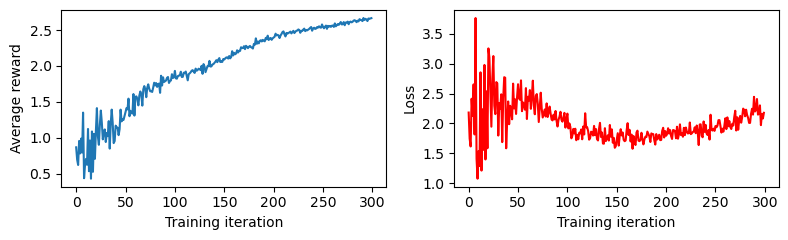

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.83it/s]


Sample trajectories: 100
[0.880, 0.510]    N1=CCS1C2=CC=CC(=C2)NC3=NC=CC(=N3)C4=CC=C(Cl)C=C4
[0.850, 0.560]    CN1C=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C(F)=C3)N4CCOCC4
[0.720, 0.690]    CC(=O)NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.870, 0.770]    C1#CN1C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=C(Cl)C=C4
[0.700, 0.490]    CN1C=C(C2=N1)C=C3C=C(CC=C23)NC4=NC=CC(=N4)C5=CC=CC=C5
[0.000, 0.000]    N#N
[0.800, 0.820]    CN1C=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.030, 0.040]    COC(=O)C=CN(C)C1=CC=CCC=CC=CN=CC=C1C=CC2=CC3=CC=CC(C)=C3S2
[0.730, 0.740]    NC1=CC=CC=C1NC(=O)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.830, 0.600]    NN(C1CC1)C2=CC=C(C=C2F)NC3=NC=CC(=N3)C4=CC=C(C=C4)N5C=CN=C5
[0.810, 0.810]    OC1=CC=C(C=C1Cl)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.780, 0.680]    O=COCCC=CCC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.490, 0.350]    FC=CC=C(CC)C1=CC=NC(=N1)NC2=CC=C(C=C2)N3CCOCC3
[0.660, 0.480]    CC1=CC=NC(=N1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.840, 0.700]    COC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=

[0316] rl_loss: 2.248	reconst_loss: 1.054	entropy_loss: 1.194	reward: 2.708	tau: 2.323	(15564.578 sec)
[0317] rl_loss: 2.222	reconst_loss: 1.019	entropy_loss: 1.203	reward: 2.657	tau: 2.326	(15609.396 sec)
[0318] rl_loss: 2.318	reconst_loss: 1.110	entropy_loss: 1.208	reward: 2.683	tau: 2.329	(15652.615 sec)
[0319] rl_loss: 2.436	reconst_loss: 1.231	entropy_loss: 1.205	reward: 2.695	tau: 2.333	(15696.887 sec)
[0320] rl_loss: 2.269	reconst_loss: 1.055	entropy_loss: 1.214	reward: 2.708	tau: 2.337	(15740.005 sec)
[0321] rl_loss: 2.301	reconst_loss: 1.088	entropy_loss: 1.213	reward: 2.703	tau: 2.340	(15784.841 sec)
[0322] rl_loss: 2.504	reconst_loss: 1.286	entropy_loss: 1.218	reward: 2.708	tau: 2.344	(15830.522 sec)
[0323] rl_loss: 2.247	reconst_loss: 1.025	entropy_loss: 1.222	reward: 2.715	tau: 2.348	(15875.777 sec)
[0324] rl_loss: 2.354	reconst_loss: 1.127	entropy_loss: 1.227	reward: 2.698	tau: 2.351	(15920.516 sec)
[0325] rl_loss: 2.379	reconst_loss: 1.150	entropy_loss: 1.229	reward: 2.7

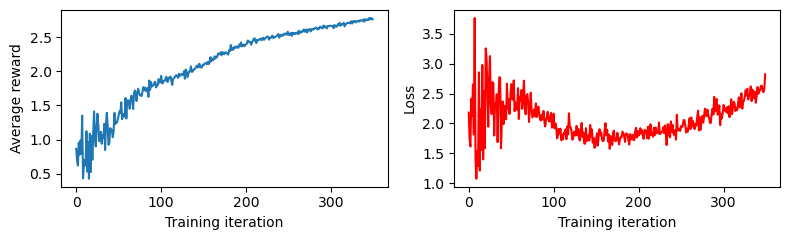

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.18it/s]


Sample trajectories: 100
[0.800, 0.740]    O=CC1=NC=CS1C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.770, 0.640]    C1=CN=CC(=C1)C2=CC=NC(=N2)NC3=CC=C(C=N3)N4CCNCC4
[0.450, 0.070]    COC1=CC=CC=C1C2=NN=C(O2)C3=CC=C(C=C3)NC=NC=C4C(=O)NC5=CC=CC=C54
[0.780, 0.690]    N=C(N1CCNCC1)C2=CC=C(C=C2)C3=CC=C(C=C3)NC4=NC=CC(=N4)C5=CC=CC=C5
[0.820, 0.770]    O=C(N1CCCC1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.800, 0.820]    CN1C=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.780, 0.840]    C1N=C1C2=CC=C(C=C2)C3=CC=NC(=N3)NC4=CC=C(C=C4)N5CCOCC5
[0.750, 0.680]    CNC(=O)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.810, 0.760]    S12C=C1C(=O)N=C2C3=CC=C(C=C3)NC4=NC=CC(=N4)C5=CC=CC=C5
[0.800, 0.680]    CC1=CC=CS1(=O)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.730, 0.490]    O=C(Cl)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3Cl
[0.010, 0.070]    O=C(C1=CC=C(O)C=C1)C=CC=CC=CC=NC=NC(CC2=CC=CC=C2Br)=C3OCOC3=N
[0.800, 0.700]    O=CCNNC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.840, 0.720]    C=C1CNC(=O)N(C1=O)C2=CC=C(C=C2)

[0364] rl_loss: 2.683	reconst_loss: 1.330	entropy_loss: 1.354	reward: 2.823	tau: 2.489	(17701.648 sec)
[0365] rl_loss: 2.701	reconst_loss: 1.345	entropy_loss: 1.356	reward: 2.823	tau: 2.492	(17746.582 sec)
[0366] rl_loss: 2.925	reconst_loss: 1.563	entropy_loss: 1.362	reward: 2.827	tau: 2.495	(17791.218 sec)
[0367] rl_loss: 2.789	reconst_loss: 1.425	entropy_loss: 1.364	reward: 2.814	tau: 2.498	(17834.876 sec)
[0368] rl_loss: 2.680	reconst_loss: 1.312	entropy_loss: 1.368	reward: 2.851	tau: 2.502	(17878.791 sec)
[0369] rl_loss: 2.747	reconst_loss: 1.380	entropy_loss: 1.368	reward: 2.817	tau: 2.505	(17922.993 sec)
[0370] rl_loss: 2.751	reconst_loss: 1.382	entropy_loss: 1.368	reward: 2.824	tau: 2.508	(17966.581 sec)
[0371] rl_loss: 2.807	reconst_loss: 1.434	entropy_loss: 1.373	reward: 2.839	tau: 2.512	(18011.767 sec)
[0372] rl_loss: 2.674	reconst_loss: 1.297	entropy_loss: 1.377	reward: 2.846	tau: 2.515	(18059.617 sec)
[0373] rl_loss: 2.700	reconst_loss: 1.322	entropy_loss: 1.378	reward: 2.8

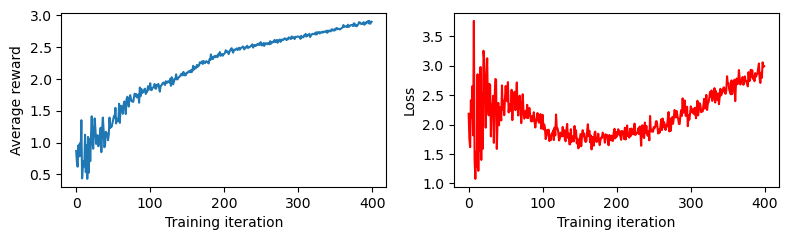

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.82it/s]


Sample trajectories: 100
[0.900, 0.600]    O=CC=CNC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=CC(=C3)NC4=NC=CC(=N4)C5=CC=CC=C5
[0.020, 0.040]    OCC=CC1=C2C=CC=CC2=CC=C1OC3=CC=CC=C3
[0.820, 0.690]    O=CNN=CC1=CC=CN=C1C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.780, 0.780]    CNC(C1=CC=C2OCOC2=C1)C3=CC=C(C=C3)C4=CC=C(C=C4)C5=CC=NC(=N5)NC6=CC=C(C=C6)N7CCOCC7
[0.810, 0.750]    O=CNCCCN1CCOCC1C2=CC=CC(=C2)C3=CC=NC(=N3)NC4=CC=C(C=C4)N5CCOCC5
[0.770, 0.650]    COCCOC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(OC)C=C3
[0.100, 0.040]    C1NC2CN3CCC2CC3C(=O)N1CC4=CC=C5OC(=C(Br)C5=C4)C6=CC=CC=C6
[0.790, 0.660]    N#CC=CC1=C(NNC1=C)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.800, 0.860]    N#CC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.010, 0.000]    C1=CCC=C2C(Br)=C(O)C(C3(C)C)=C2C=C31
[0.760, 0.830]    NC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.860, 0.730]    C1=CC=C(C=C1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.780, 0.710]    CCOCC(O)CNC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.870, 0.700]   

[0410] rl_loss: 2.982	reconst_loss: 1.495	entropy_loss: 1.487	reward: 2.926	tau: 2.632	(19757.743 sec)
[0411] rl_loss: 3.058	reconst_loss: 1.559	entropy_loss: 1.499	reward: 2.943	tau: 2.635	(19803.467 sec)
[0412] rl_loss: 3.127	reconst_loss: 1.633	entropy_loss: 1.495	reward: 2.912	tau: 2.638	(19848.981 sec)
[0413] rl_loss: 3.027	reconst_loss: 1.527	entropy_loss: 1.500	reward: 2.941	tau: 2.641	(19892.710 sec)
[0414] rl_loss: 2.953	reconst_loss: 1.445	entropy_loss: 1.508	reward: 2.936	tau: 2.644	(19937.038 sec)
[0415] rl_loss: 3.119	reconst_loss: 1.603	entropy_loss: 1.517	reward: 2.925	tau: 2.647	(19980.888 sec)
[0416] rl_loss: 2.846	reconst_loss: 1.331	entropy_loss: 1.515	reward: 2.915	tau: 2.650	(20025.893 sec)
[0417] rl_loss: 3.024	reconst_loss: 1.518	entropy_loss: 1.506	reward: 2.946	tau: 2.653	(20069.131 sec)
[0418] rl_loss: 3.252	reconst_loss: 1.737	entropy_loss: 1.515	reward: 2.932	tau: 2.655	(20114.299 sec)
[0419] rl_loss: 3.123	reconst_loss: 1.595	entropy_loss: 1.529	reward: 2.9

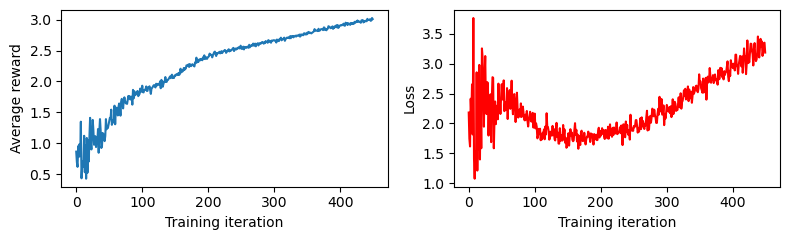

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.97it/s]


Sample trajectories: 100
[0.800, 0.760]    N#CC1=CC=C(C=C1)C2=CC=NC(=C2)C3=CC=NC(=N3)NC4=CC=C(C=C4)N5CCOCC5
[0.390, 0.650]    O=CN=CC1=CC=C(C=C1)NC2=CC(=CC=N2)C3=CC=NC(=N3)N4C=CN=C4
[0.000, 0.000]    O=CCCC#N
[0.790, 0.780]    N1C2=CN(CC=C12)C3=CC(=CC=N3)C4=CC=NC(=N4)NC5=CC=C(C=C5)N6CCOCC6
[0.790, 0.580]    CCON=C(C1=CC=C(F)C=C1)C2=CC=C(C=C2)C3=CC=NC(=N3)NC4=CC=C(C=C4)S
[0.730, 0.630]    CCSCNN=CC1=CC=C(N1)C2=CC=C(C=C2)C3=CC=NC(=N3)NC4=CC=C(C=C4)N5CCNCC5
[0.080, 0.010]    C1C=NN(C2=CC=C(Cl)C=C2Cl)C(=N1)C3=CC4=C(C=C3)CCCC4=O
[0.320, 0.090]    OC1=CC=C(C=C1)C=C2C=CNC=CC=C3N=CSC3C=C2C(N4CCOCC4)C5=CC=C(C=C5)C=CC6=NC(N)=NC(=C6)C7=CC=C(C=C7)N8CCCC8CN9C=CC=N9
[0.620, 0.540]    O=C(NCC1CC1)C2=CC=C(C=C2)C3=CC=NC(=N3)NC4=CC=C(C=C4)N5CCOCC5CNN=C(OCC)N=C6N=C(Br)C=CC6=[N+1][O-1]
[0.370, 0.320]    O=C(N1CC2CC1CO2)C3=CC=C(C=C3)NC=NC=CCSC=NC=CC=CC(P(O)(O)=O)C4=CC=NC(=N4)NC5=CC=C(C=C5)N6CCOCC6
[0.180, 0.070]    OC1=CC=CC(=C1)C2=CC=NC(=N2)C3=CC=C(C=C3)C4=CC5=NC(=N4)OC5
[0.040, 0.000]    C1=NN1CC2=CN(N=N

[0457] rl_loss: 3.252	reconst_loss: 1.641	entropy_loss: 1.611	reward: 3.004	tau: 2.761	(21853.540 sec)
[0458] rl_loss: 3.324	reconst_loss: 1.706	entropy_loss: 1.618	reward: 3.008	tau: 2.764	(21897.589 sec)
[0459] rl_loss: 3.401	reconst_loss: 1.794	entropy_loss: 1.607	reward: 3.024	tau: 2.766	(21941.316 sec)
[0460] rl_loss: 3.654	reconst_loss: 2.036	entropy_loss: 1.618	reward: 3.025	tau: 2.769	(21984.070 sec)
[0461] rl_loss: 3.369	reconst_loss: 1.763	entropy_loss: 1.606	reward: 3.018	tau: 2.772	(22028.100 sec)
[0462] rl_loss: 3.487	reconst_loss: 1.880	entropy_loss: 1.607	reward: 3.034	tau: 2.774	(22071.248 sec)
[0463] rl_loss: 4.062	reconst_loss: 2.466	entropy_loss: 1.597	reward: 3.028	tau: 2.777	(22120.970 sec)
[0464] rl_loss: 3.734	reconst_loss: 2.102	entropy_loss: 1.632	reward: 3.018	tau: 2.779	(22170.841 sec)
[0465] rl_loss: 3.455	reconst_loss: 1.813	entropy_loss: 1.642	reward: 3.034	tau: 2.782	(22237.066 sec)
[0466] rl_loss: 3.845	reconst_loss: 2.231	entropy_loss: 1.614	reward: 3.0

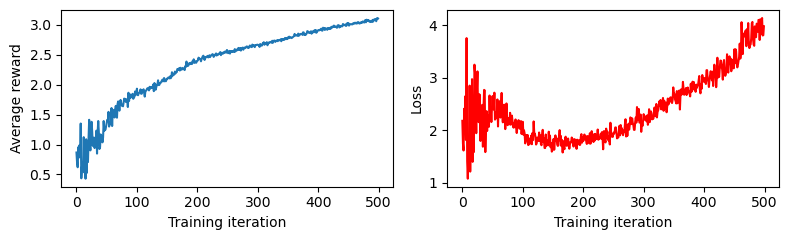

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.20it/s]


Sample trajectories: 100
[0.250, 0.030]    N#CC1=CC=CC(=C1)C=C2C=NC(=CN2)C3=CC(=CN3)N
[0.040, 0.000]    CCNC1=CC=C(C=C1)NC=NC2=CC(C)=CC3=C2N=NC4=CC=CC=C34
[0.050, 0.010]    CSC1=CC2=C(C=N1)N=N2
[0.610, 0.140]    N#CC1=CC=C(C=C1)C=CC=NCC=CC2=CC=NC=C2C3=CC=C(C=C3)NC(=O)C4=CC=C(N=C45)NC=NC6=CC7=CC=NC(F)=C7N=C56
[0.750, 0.890]    C=CC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4C=NC=N4
[0.820, 0.750]    N#CC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=C3)C4CC5CCC4C5
[0.000, 0.000]    C=CSCOCC1=CC=CC=N1
[0.120, 0.060]    CNC=CC=CCCN1C=NC=C1C=CC=NCCCCCOCNC2=CC=C(C=C2OC)OC3=CC=CC4=C3OCC5=C4OCO5
[0.600, 0.470]    O=C(CC)NC1=CC=C(C=C1Cl)C2=CC=NC(=N2)NC3=CC=C(C=C34)COCCO4
[0.700, 0.740]    N#CC=C(C1=CC=CN=C1)C=C(N2CC3NCC2)CCCCC3C4=CC=C(C=C4)C5=CC=NC(=N5)NC6=CC=C(C=C6)N7CCNCC7
[0.050, 0.030]    N#CC1=CC=C(C=C1)C=CC=C2CNC(=O)NC2=O
[0.110, 0.030]    NCC1=CC=C(C=C1)C=CC=NC(C=NN)C2=CC=C(C3=C2)C=CN3
[0.030, 0.000]    N1CCN=C1CCC2=C(F)C=CC=C2F
[0.730, 0.440]    OCC1=CC=C(C=C1Cl)C2=CC=NC(=N2)NC3=CC4=C(NN=C4S3)N5CCOC

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

gsk_list = []
jnk_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.2
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_gsk = 0.
    avg_jnk = 0.
    
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, s_gsk, s_jnk = my_reward_ft(sm, debug=True)
                print(f"[{s_gsk:.3f}, {s_jnk:.3f}]    {sm}")
                avg_gsk += s_gsk
                avg_jnk += s_jnk
            avg_gsk /= len(smiles_cur)
            avg_jnk /= len(smiles_cur)
    
    ## append - binding affinity values
    gsk_list.append(avg_gsk)
    jnk_list.append(avg_jnk)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                      gsk_list, jnk_list,
                      execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

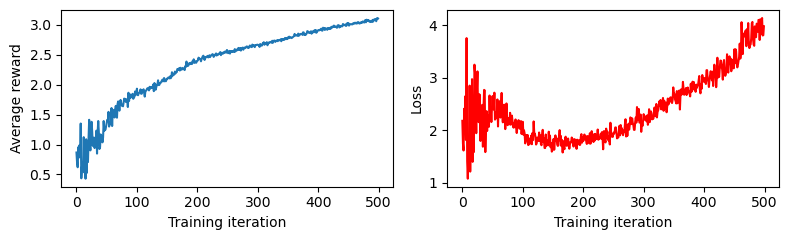

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                           gsk_list, jnk_list,
                           execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 7)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  GSK3  JNK3   EXEC_TIME
0  0.866598  2.182365      2.097577      0.084788   0.0   0.0   31.083502
1  0.694890  1.747620      1.660784      0.086836   0.0   0.0   65.691703
2  0.620690  1.616566      1.527152      0.089414   0.0   0.0  108.577855
3  0.955488  2.413032      2.327175      0.085857   0.0   0.0  168.558621
4  0.781755  2.125010      2.039411      0.085599   0.0   0.0  288.360195


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [19:18<00:00, 25.89it/s]


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/gsk3_jnk3/smi_after.csv
